# Import packages

In [2]:
import sys
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import json
#import visdom
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error, r2_score
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler #, TensorDataset
import random
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, matthews_corrcoef, average_precision_score, PrecisionRecallDisplay, accuracy_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
from sklearn.utils.class_weight import compute_class_weight
#from cuml.svm import SVC
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    return


In [3]:
if torch.cuda.is_available():
    print("CUDA is available. GPU will be used.")
    device = torch.device("cuda")
else:
    print("CUDA is not available. CPU will be used.")
    device = torch.device("cpu")

print(f"Using device: {device}")


CUDA is available. GPU will be used.
Using device: cuda


# Define Functions

In [4]:
# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

class TensorDataset(Dataset):
    def __init__(self, data, y1):
        self.data = data
        self.y1 = y1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.y1[idx]

    def get_labels(self):
        return self.y1  # Return labels directly

# Custom batch sampler to ensure each class is represented without replacement
class ClassRepresentedSampler:
    def __init__(self, dataset, batch_size, seed=42):
        dataset.labels = dataset.get_labels().cpu().numpy()  # Assuming labels are retrieved from the dataset
        self.dataset = dataset
        self.batch_size = batch_size
        self.num_classes, self.classes = self.get_classes_count(dataset)

        # Set the random seed if provided for reproducibility
        if seed is not None:
            np.random.seed(seed)
            torch.manual_seed(seed)

    def get_classes_count(self, dataset):
        # This function calculates the number of classes and class indices in the dataset
        classes, counts = np.unique(dataset.labels, return_counts=True)
        return len(classes), classes

    def __iter__(self):
        # Shuffle the dataset indices
        indices = np.arange(len(self.dataset))
        np.random.shuffle(indices)

        used_indices = set()  # To keep track of used indices

        # Create batches
        while len(used_indices) < len(self.dataset):
            batch_indices = []
            for cls in self.classes:
                # Get indices for the current class
                class_indices = np.where(self.dataset.labels[indices] == cls)[0]
                np.random.shuffle(class_indices)  # Shuffle class indices for randomness

                for index in class_indices:
                    if indices[index] not in used_indices:
                        batch_indices.append(indices[index])
                        used_indices.add(indices[index])
                        break  # Ensure only one sample per class is added

            # Fill remaining batch size with random samples, ensuring no replacement
            while len(batch_indices) < self.batch_size and len(used_indices) < len(self.dataset):
                random_index = np.random.choice(indices)  # Randomly select an index
                if isinstance(random_index, np.ndarray):
                    random_index = random_index.item()  # Flatten the choice
                if random_index not in used_indices:
                    batch_indices.append(random_index)
                    used_indices.add(random_index)

            # Only yield the batch if it meets the batch size requirement
            if len(batch_indices) == self.batch_size:
                yield batch_indices  # Return batch indices

    def __len__(self):
        return (len(self.dataset) + self.batch_size - 1) // self.batch_size  # Total number of batches

class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()
        # Linear layer to compute attention scores for each time step
        self.attention_weights = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # x: [batch_size, seq_len, hidden_size]
        # Compute attention scores for each time step
        attn_scores = self.attention_weights(x)  # [batch_size, seq_len, 1]

        # Apply softmax to get the attention weights
        attn_scores = torch.softmax(attn_scores, dim=1)  # [batch_size, seq_len, 1]

        # Multiply input x with attention scores (broadcasting) and sum over the sequence length
        weighted_output = torch.sum(x * attn_scores, dim=1)  # [batch_size, hidden_size]

        return weighted_output


class TeLU(nn.Module):
    # Fernandez and Mali 2024
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return input * torch.tanh( torch.exp(input) )

# Load the data

In [5]:
def apply_smote(train_data, train_y1, device):
    """
    Applies SMOTE to the input train_data and train_y1 tensors to handle class imbalance.
    Returns the resampled train_data and train_y1 as tensors.

    Args:
    - train_data (torch.Tensor): The training features.
    - train_y1 (torch.Tensor): The training labels.
    - device (torch.device): Device to which the tensors should be moved (CPU/GPU).

    Returns:
    - train_data_resampled_tensor (torch.Tensor): Resampled training features.
    - train_y1_resampled_tensor (torch.Tensor): Resampled training labels.
    """
    # Convert train_data and train_y1 from torch tensors to numpy arrays
    train_data_np = train_data.cpu().numpy()  # Move to CPU if necessary and convert to numpy
    train_y1_np = train_y1.cpu().numpy()

    # Apply SMOTE to the training data and labels
    smote = SMOTE(random_state=42)  # You can set random_state for reproducibility
    train_data_resampled, train_y1_resampled = smote.fit_resample(train_data_np, train_y1_np)

    # Convert the resampled data back to torch tensors
    train_data_resampled_tensor = torch.tensor(train_data_resampled, dtype=torch.float32).to(device)
    train_y1_resampled_tensor = torch.tensor(train_y1_resampled, dtype=torch.long).to(device)

    return train_data_resampled_tensor, train_y1_resampled_tensor

# Example of usage:
# train_data_resampled, train_y1_resampled = apply_smote(train_data, train_y1, device)






In [8]:

model_code = 'XGBoost_1_wNeg_kcat'

result_filename_csv = f"dual_{model_code}_results.xlsx"
output_location = f'Dual_{model_code}'



save_dir = '/content/'         # ESM-2 rep only [Train, Val, Test have the negative Dataset ++ these Uniprot+Interpro] # removed TestCatAwareSet

test_data_NoSMOTE, test_y1_NoSMOTE, _ = torch.load(f'{save_dir}/test_dataset.pt')
test_data_NoSMOTE, test_y1_NoSMOTE = test_data_NoSMOTE.to(device), test_y1_NoSMOTE.to(device)
test_dataset_NoSMOTE_org = TensorDataset(test_data_NoSMOTE, test_y1_NoSMOTE)

X_test_WT_tensor, X_test_MD_Ala_tensor, y1_test_WT_tensor, y2_test_WT_tensor = torch.load(f'{save_dir}/testCatAware_dataset.pt')
X_test_WT_tensor, X_test_MD_Ala_tensor, y1_test_WT_tensor, y2_test_WT_tensor  = X_test_WT_tensor.to(device), X_test_MD_Ala_tensor.to(device), y1_test_WT_tensor.to(device), y2_test_WT_tensor.to(device)
testCatAware_WT_dataset_org  = TensorDataset(X_test_WT_tensor, y1_test_WT_tensor)
testCatAware_MD_dataset_org  = TensorDataset(X_test_MD_Ala_tensor, y1_test_WT_tensor)

train_data, train_y1, _ = torch.load(f'{save_dir}/train_dataset_wNeg.pt')
val_data, val_y1,  _ = torch.load(f'{save_dir}/val_dataset_wNeg.pt')
test_data, test_y1,  _ = torch.load(f'{save_dir}/test_dataset_wNeg.pt')

X_PafA_tensor, y1_PafA_tensor, y2_PafA_tensor = torch.load(f'{save_dir}/PafA_1_test_dataset_2.pt')
# X_PafA_tensor, y1_PafA_tensor, y2_PafA_tensor = torch.load(f'{save_dir}/PafA_1_val_test_dataset.pt')
X_PafA_tensor, y1_PafA_tensor, y2_PafA_tensor  = X_PafA_tensor.to(device), y1_PafA_tensor.to(device), y2_PafA_tensor.to(device)
PafA_dataset_org  = TensorDataset(X_PafA_tensor, y1_PafA_tensor)

# train_data_PafA, train_y1_PafA, _ = torch.load(f'{save_dir}/PafA_1_train_dataset.pt')
train_data_PafA, train_y1_PafA, _ = torch.load(f'{save_dir}/PafA_1_train_dataset_2.pt')
# train_data_PafA, train_y1_PafA  = apply_smote(train_data_PafA, train_y1_PafA, device)
train_data_PafA, train_y1_PafA = train_data_PafA.to(device), train_y1_PafA.to(device)

# val_data_PafA, val_y1_PafA, _ = torch.load(f'{save_dir}/PafA_1_val_dataset.pt')
val_data_PafA, val_y1_PafA, _ = torch.load(f'{save_dir}/PafA_1_val_dataset_2.pt')
# val_data_PafA, val_y1_PafA  = apply_smote(val_data_PafA, val_y1_PafA, device)
val_data_PafA, val_y1_PafA = val_data_PafA.to(device), val_y1_PafA.to(device)


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

combined_data = torch.cat([train_data, val_data, test_data], dim=0)
combined_labels = torch.cat([train_y1, val_y1, test_y1], dim=0)



combined_data , combined_labels  = apply_smote(combined_data, combined_labels, device)


train_data, X_temp, train_y1, y_temp = train_test_split(combined_data, combined_labels, test_size=0.2, random_state=42)
val_data, test_data, val_y1, test_y1 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


train_data = torch.cat([train_data, train_data_PafA], dim=0)
train_y1 = torch.cat([train_y1, train_y1_PafA], dim=0)
train_data, train_y1 = apply_smote(train_data, train_y1, device)

val_data = torch.cat([val_data, val_data_PafA], dim=0)
val_y1 = torch.cat([val_y1, val_y1_PafA], dim=0)
val_data, val_y1 = apply_smote(val_data, val_y1, device)

# Move data to the GPU
train_data, train_y1 = train_data.to(device), train_y1.to(device)
val_data, val_y1 = val_data.to(device), val_y1.to(device)
test_data, test_y1= test_data.to(device), test_y1.to(device)

train_dataset_org = TensorDataset(train_data, train_y1)
val_dataset_org = TensorDataset(val_data, val_y1)
test_dataset_org = TensorDataset(test_data, test_y1)



<ipython-input-8-6086bb21533b>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data_NoSMOTE, test_y1_NoSMOTE, _ = torch.load(f'{save_dir}/test_dataset.pt')
<ipython-i

Using device: cuda


# Standardize Dataset

In [9]:
# Global standardization function for two feature groups (X1 and X2)
def standardize_x_global_separate(data, global_mean_1, global_std_1, global_mean_2, global_std_2):
    # Split data into two groups: X1 (first 1280) and X2 (rest)
    X1, X2 = data[:, :1280], data[:, 1280:]
    # Ensure standard deviation is not zero to avoid division by zero
    global_std_1 = torch.clamp(global_std_1, min=1e-7)
    global_std_2 = torch.clamp(global_std_2, min=1e-7)

    # Standardize each group separately
    X1_standardized = (X1 - global_mean_1) / global_std_1
    X2_standardized = (X2 - global_mean_2) / global_std_2

    # Concatenate the standardized X1 and X2 back together
    standardized_data = torch.cat((X1_standardized, X2_standardized), dim=1).squeeze(1)
    # print(standardized_data.shape)
    return standardized_data

# StandardizedDataset class for global standardization of two groups
class StandardizedDatasetGlobalSeparate(Dataset):
    def __init__(self, subset, global_mean_1, global_std_1, global_mean_2, global_std_2):
        self.subset = subset
        self.global_mean_1 = global_mean_1
        self.global_std_1 = global_std_1
        self.global_mean_2 = global_mean_2
        self.global_std_2 = global_std_2

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        x, y1 = self.subset[idx]
        # print(f"Shape of x before processing: {x.shape}")
        if len(x.shape) == 1:
            x = x.unsqueeze(1)
        # print(f"Shape of x after ensuring 2D: {x.shape}")
        x_standardized = standardize_x_global_separate(x, self.global_mean_1, self.global_std_1, self.global_mean_2, self.global_std_2)
        return x_standardized, y1


    def get_labels(self):
        return torch.tensor([y1 for _, y1 in self.subset])

# Compute global mean and std for each feature group (first 1280 and the rest) from the train dataset
def get_train_stats_separate(train_dataset, shuffle_data=False):
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=shuffle_data)
    train_batch = next(iter(train_loader))
    train_data, train_y1 = train_batch
    # Split the data into two parts
    X1, X2 = train_data[:, :1280], train_data[:, 1280:]
    # Calculate mean and std for each part
    # print(X2.shape)
    global_mean_1 = X1.mean()
    global_std_1 = X1.std()
    global_mean_2 = X2.mean()
    global_std_2 = X2.std()

    print(f"\n Before Global Standardization (Train Dataset):")
    print(f"X1 Mean: {global_mean_1.item()}, X1 Std: {global_std_1.item()}")
    print(f"X2 Mean: {global_mean_2.item()}, X2 Std: {global_std_2.item()}")

    return global_mean_1, global_std_1, global_mean_2, global_std_2

# Apply the global standardization to the dataset
def apply_global_standardization_separate(dataset, global_mean_1, global_std_1, global_mean_2, global_std_2):
    standardized_dataset = StandardizedDatasetGlobalSeparate(dataset, global_mean_1, global_std_1, global_mean_2, global_std_2)
    return standardized_dataset

# Retrieve global mean and std for the two feature groups from the train dataset
global_mean_1, global_std_1, global_mean_2, global_std_2 = get_train_stats_separate(train_dataset_org)


# Apply standardization to train, validation, and test datasets using the stats from the train dataset
train_dataset = apply_global_standardization_separate(train_dataset_org, global_mean_1, global_std_1, global_mean_2, global_std_2)
val_dataset = apply_global_standardization_separate(val_dataset_org, global_mean_1, global_std_1, global_mean_2, global_std_2)  # Use train stats
test_dataset = apply_global_standardization_separate(test_dataset_org, global_mean_1, global_std_1, global_mean_2, global_std_2)  # Use train stats

# Function to check the mean and std after standardization for the validation and test datasets
def get_val_test_stats_separate(dataset, dataset_name=""):
    data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    data_batch = next(iter(data_loader))
    data, y1 = data_batch
    # Split data back into two parts for checking mean and std
    X1, X2 = data[:, :1280], data[:, 1280:]

    mean_data_1 = X1.mean()
    std_data_1 = X1.std()
    # print(X1.shape)
    mean_data_2 = X2.mean()
    std_data_2 = X2.std()

    print(f"\nAfter Global Standardization ({dataset_name} Dataset):")
    print(f"X1 Mean: {mean_data_1.item()}, X1 Std: {std_data_1.item()}")
    print(f"X2 Mean: {mean_data_2.item()}, X2 Std: {std_data_2.item()}")


# Check stats for validation and test datasets after standardization
get_val_test_stats_separate(train_dataset, "Train")
get_val_test_stats_separate(val_dataset, "Validation")
get_val_test_stats_separate(test_dataset, "Test")

# Convert datasets to tensors for saving
def dataset_to_tensors_separate(dataset):
    data_loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
    data_batch = next(iter(data_loader))
    data, y1 = data_batch
    return data, y1

train_data, train_y1 = dataset_to_tensors_separate(train_dataset)
val_data, val_y1 = dataset_to_tensors_separate(val_dataset)
test_data, test_y1 = dataset_to_tensors_separate(test_dataset)

# Save the tensors
torch.save((train_data, train_y1), f'{save_dir}/train_dataset_std_kcat.pt')
torch.save((val_data, val_y1), f'{save_dir}/val_dataset_std_kcat.pt')
torch.save((test_data, test_y1), f'{save_dir}/test_dataset_std_kcat.pt')



 Before Global Standardization (Train Dataset):
X1 Mean: -0.0006011285004206002, X1 Std: 0.18902993202209473
X2 Mean: -0.00015002528380136937, X2 Std: 0.6113553047180176

After Global Standardization (Train Dataset):
X1 Mean: -2.1215138534813605e-09, X1 Std: 1.0
X2 Mean: 0.0023864256218075752, X2 Std: 3.2341721057891846

After Global Standardization (Validation Dataset):
X1 Mean: 1.6336456383214681e-06, X1 Std: 0.9994407892227173
X2 Mean: 0.0024064138997346163, X2 Std: 3.221193790435791

After Global Standardization (Test Dataset):
X1 Mean: 1.9736547983484343e-05, X1 Std: 0.9988380670547485
X2 Mean: 0.002369687659665942, X2 Std: 3.2350916862487793


In [10]:


# Find the global minimum and maximum for train, validation, and test data
train_min, train_max = torch.min(train_data), torch.max(train_data)
val_min, val_max = torch.min(val_data), torch.max(val_data)
test_min, test_max = torch.min(test_data), torch.max(test_data)

print("Train data - Min:", train_min.item(), "Max:", train_max.item())
print("Validation data - Min:", val_min.item(), "Max:", val_max.item())
print("Test data - Min:", test_min.item(), "Max:", test_max.item())

Train data - Min: -45.848365783691406 Max: 18.61212158203125
Validation data - Min: -44.56120300292969 Max: 18.25925064086914
Test data - Min: -44.39772033691406 Max: 17.786575317382812


In [11]:
# Convert y1_train and y2_train to pandas series if they aren't already
y1_train_series = pd.Series(train_y1.cpu().numpy())

# Calculate class counts for y1_train and y2_train
class_counts_y1 = y1_train_series.value_counts().sort_index().to_dict()
# Output the class counts
print(f"class_counts_y1 = {class_counts_y1}")
classes_y1_true = list(class_counts_y1.keys())

input_size = train_data.shape[1] # 2048

output_size1 = len(classes_y1_true)

train_y1 = train_y1.reshape(-1, 1)
val_y1 = val_y1.reshape(-1, 1)
test_y1 = test_y1.reshape(-1, 1)

# Directories
os.makedirs(output_location, exist_ok=True)

class_counts_y1 = {0: 13615, 1: 13615, 2: 13615, 3: 13615, 4: 13615, 5: 13615, 6: 13615, 7: 13615}


# Examine Dataset

[63559, 15596]


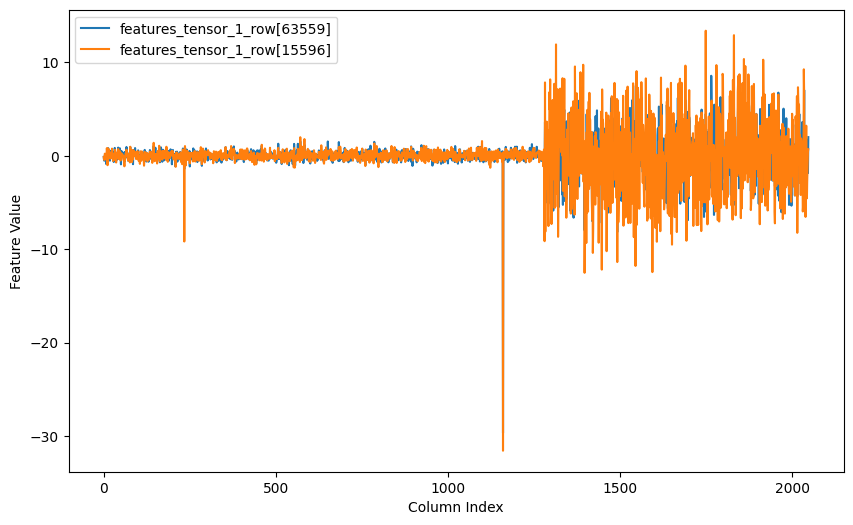

In [12]:

# Plotting the first feature of each tensor
plt.figure(figsize=(10, 6))

# Select random 'n' rows
n = 2  # You can change this value to any number of rows
random_indices = random.sample(range(train_data.shape[0]), n)
print(random_indices)
# random_indices = [3581]

for i in random_indices:
    plt.plot(train_data[i, :].cpu(), label=f"features_tensor_1_row[{i}]")
    # plt.plot(train_data[i, :1280].cpu(), label=f"features_tensor_1_row[{i}]")

# Adding labels and title
# plt.title('Comparison of features_tensor_1[0] and features_tensor_2[0]')
plt.xlabel('Column Index')
plt.ylabel('Feature Value')
# plt.ylim(-1.2*50, 1.2*50)
# plt.ylim(0, 0.00005)
plt.legend()

# Display the plot
plt.show()



In [13]:
# # Apply standardization to the test tensors using train_mean_data and train_std_data
testCatAware_WT_dataset_std = apply_global_standardization_separate(testCatAware_WT_dataset_org, global_mean_1, global_std_1, global_mean_2, global_std_2)
testCatAware_MD_dataset_std = apply_global_standardization_separate(testCatAware_MD_dataset_org, global_mean_1, global_std_1, global_mean_2, global_std_2)  # Use train stats

get_val_test_stats_separate(testCatAware_WT_dataset_std, "Test_CatAware_WT")
get_val_test_stats_separate(testCatAware_MD_dataset_std, "Test_CatAware_MD")

X_CatAware_WT_test_data, test_CatAware_WT_y1 = dataset_to_tensors_separate(testCatAware_WT_dataset_std)
X_CatAware_MD_test_data, test_CatAware_MD_y1 = dataset_to_tensors_separate(testCatAware_MD_dataset_std)



After Global Standardization (Test_CatAware_WT Dataset):
X1 Mean: 0.00016129900177475065, X1 Std: 1.0218660831451416
X2 Mean: 0.0023906128481030464, X2 Std: 3.4195568561553955

After Global Standardization (Test_CatAware_MD Dataset):
X1 Mean: 0.00011758097389247268, X1 Std: 1.0268666744232178
X2 Mean: 0.0023906128481030464, X2 Std: 3.4195568561553955


In [14]:
# npoints = 2048
npoints = 1280
features_tensor = X_CatAware_WT_test_data[:, :npoints]
negative_features_tensor = X_CatAware_MD_test_data[:, :npoints]


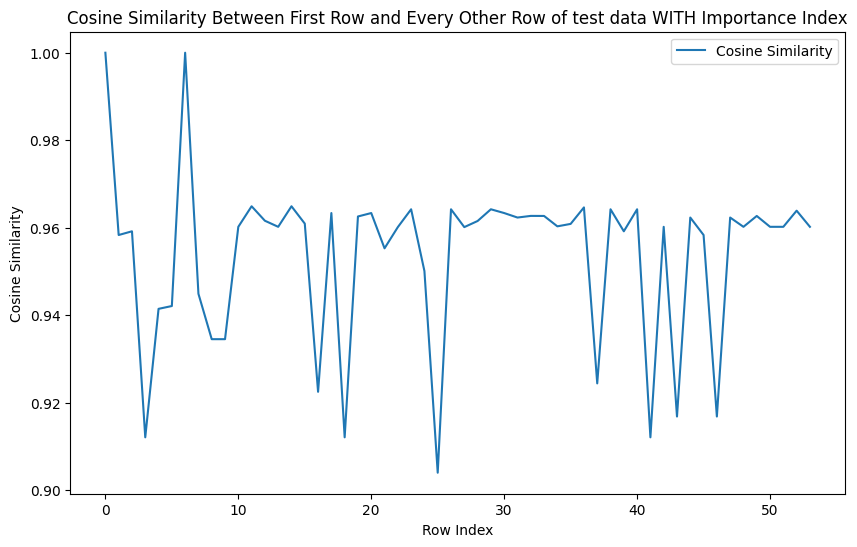

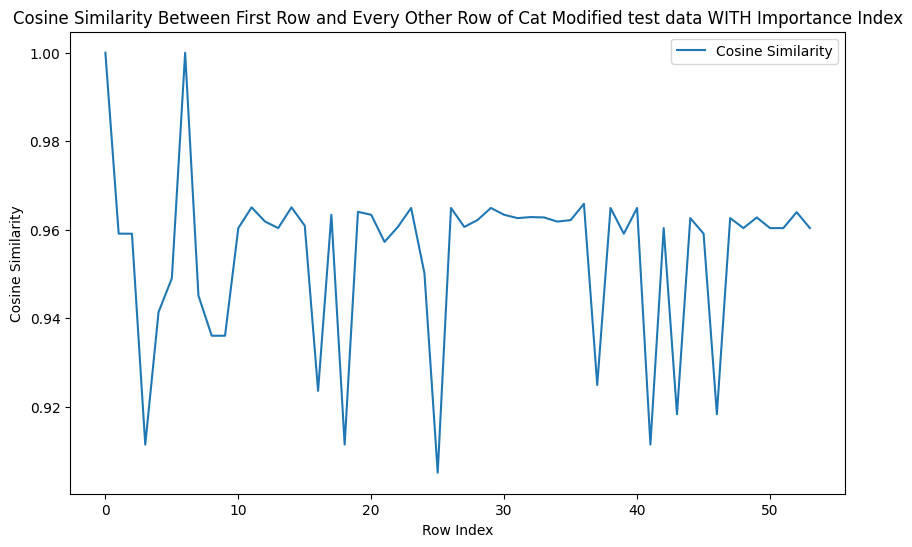

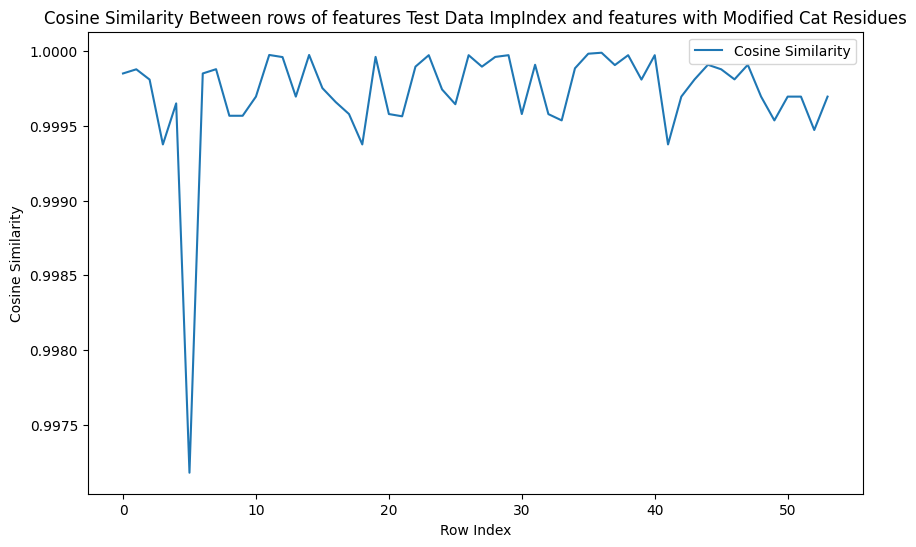

In [15]:


# Assuming train_data is a torch tensor of shape (19772, 2048)
# Extract the first row
first_row = features_tensor[0, :]

# Compute the cosine similarity between the first row and all other rows
cosine_sim = F.cosine_similarity(features_tensor, first_row.unsqueeze(0), dim=1)

# Convert cosine similarity to numpy for plotting
cosine_sim_np = cosine_sim.cpu().numpy()

# Plot the cosine similarity values
plt.figure(figsize=(10, 6))
plt.plot(cosine_sim_np, label='Cosine Similarity')
plt.xlabel('Row Index')
plt.ylabel('Cosine Similarity')
# plt.title('Cosine Similarity Between First Row and Every Other Row of train data WITHOUT Importance Index')
plt.title('Cosine Similarity Between First Row and Every Other Row of test data WITH Importance Index')
plt.legend()
plt.show()



# Assuming train_data is a torch tensor of shape (19772, 2048)
# Extract the first row
first_row_neg = negative_features_tensor[0, :]

# Compute the cosine similarity between the first row and all other rows
cosine_sim = F.cosine_similarity(negative_features_tensor, first_row_neg.unsqueeze(0), dim=1)

# Convert cosine similarity to numpy for plotting
cosine_sim_np_neg = cosine_sim.cpu().numpy()

# Plot the cosine similarity values
plt.figure(figsize=(10, 6))
plt.plot(cosine_sim_np_neg, label='Cosine Similarity')
plt.xlabel('Row Index')
plt.ylabel('Cosine Similarity')
# plt.title('Cosine Similarity Between First Row and Every Other Row of train data WITHOUT Importance Index')
plt.title('Cosine Similarity Between First Row and Every Other Row of Cat Modified test data WITH Importance Index')
plt.legend()
plt.show()

# Compute the cosine similarity between the first row and all other rows
cosine_sim = F.cosine_similarity(features_tensor, negative_features_tensor, dim=1)

# Convert cosine similarity to numpy for plotting
cosine_sim_np = cosine_sim.cpu().numpy()

# Plot the cosine similarity values
plt.figure(figsize=(10, 6))
plt.plot(cosine_sim_np, label='Cosine Similarity')
plt.xlabel('Row Index')
plt.ylabel('Cosine Similarity')
plt.title('Cosine Similarity Between rows of features Test Data ImpIndex and features with Modified Cat Residues')
plt.legend()
plt.show()


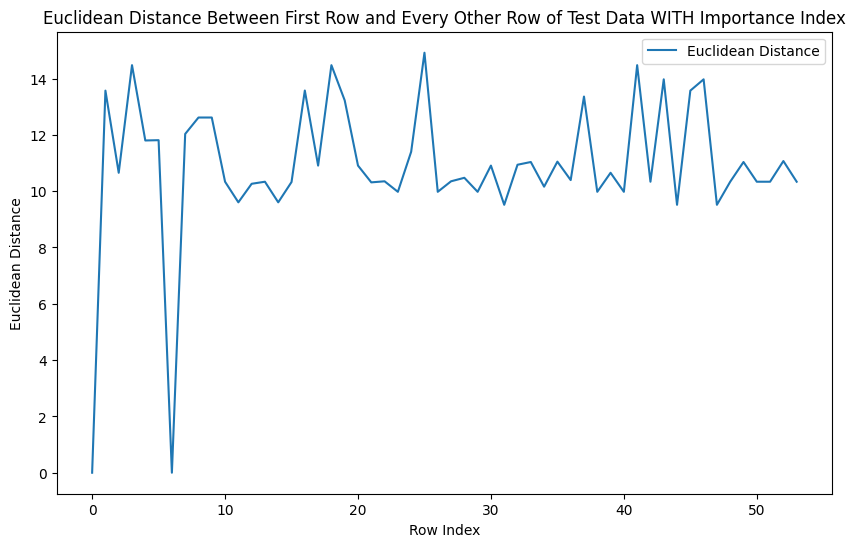

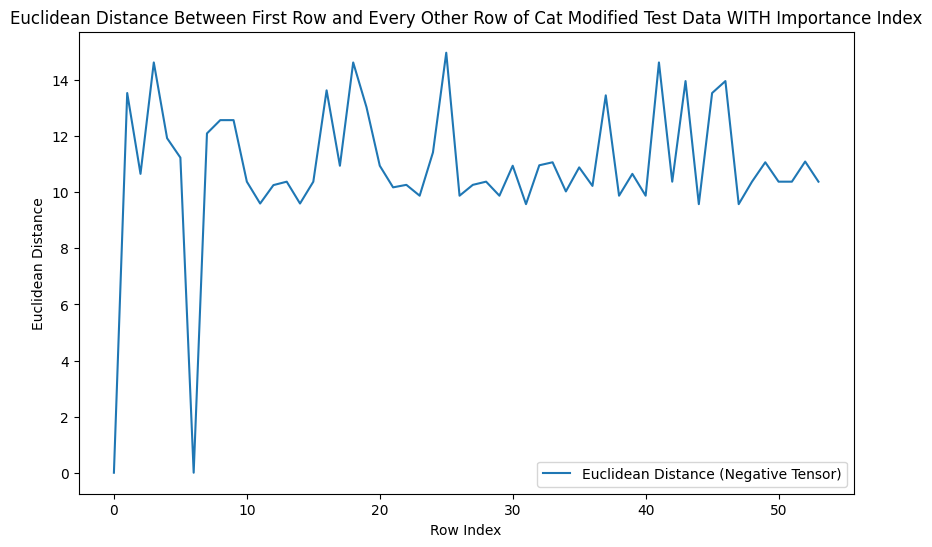

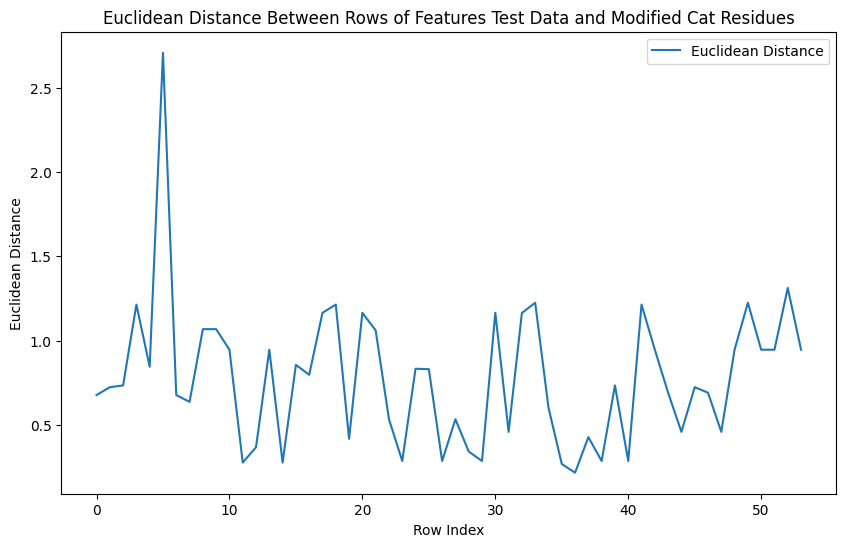

In [16]:


# Assuming features_tensor is a torch tensor of shape (19772, 2048)
# Extract the first row
first_row = features_tensor[0, :]

# Compute the Euclidean distance between the first row and all other rows
euclidean_dist = torch.norm(features_tensor - first_row.unsqueeze(0), dim=1)

# Convert Euclidean distances to numpy for plotting
euclidean_dist_np = euclidean_dist.cpu().numpy()

# Plot the Euclidean distance values
plt.figure(figsize=(10, 6))
plt.plot(euclidean_dist_np, label='Euclidean Distance')
plt.xlabel('Row Index')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance Between First Row and Every Other Row of Test Data WITH Importance Index')
plt.legend()
plt.show()

# For the negative features tensor
# Extract the first row
first_row_neg = negative_features_tensor[0, :]

# Compute the Euclidean distance between the first row and all other rows
euclidean_dist_neg = torch.norm(negative_features_tensor - first_row_neg.unsqueeze(0), dim=1)

# Convert Euclidean distances to numpy for plotting
euclidean_dist_np_neg = euclidean_dist_neg.cpu().numpy()

# Plot the Euclidean distance values for the negative tensor
plt.figure(figsize=(10, 6))
plt.plot(euclidean_dist_np_neg, label='Euclidean Distance (Negative Tensor)')
plt.xlabel('Row Index')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance Between First Row and Every Other Row of Cat Modified Test Data WITH Importance Index')
plt.legend()
plt.show()

# Compute the Euclidean distance between rows of features_tensor and negative_features_tensor
euclidean_dist_combined = torch.norm(features_tensor - negative_features_tensor, dim=1)

# Convert Euclidean distances to numpy for plotting
euclidean_dist_combined_np = euclidean_dist_combined.cpu().numpy()

# Plot the Euclidean distance values between features tensor and negative features tensor
plt.figure(figsize=(10, 6))
plt.plot(euclidean_dist_combined_np, label='Euclidean Distance')
plt.xlabel('Row Index')
plt.ylabel('Euclidean Distance')
plt.title('Euclidean Distance Between Rows of Features Test Data and Modified Cat Residues')
plt.legend()
plt.show()


## Convert Data to CPU

In [17]:
# Find the global minimum and maximum for train, validation, and test data
train_min, train_max = torch.min(train_data), torch.max(train_data)
val_min, val_max = torch.min(val_data), torch.max(val_data)
test_min, test_max = torch.min(test_data), torch.max(test_data)

print("Train data - Min:", train_min.item(), "Max:", train_max.item())
print("Validation data - Min:", val_min.item(), "Max:", val_max.item())
print("Test data - Min:", test_min.item(), "Max:", test_max.item())

# Convert tensors to numpy arrays
train_data, train_y1= train_data.cpu().numpy(), train_y1.cpu().numpy()
val_data, val_y1 = val_data.cpu().numpy(), val_y1.cpu().numpy()
test_data, test_y1 = test_data.cpu().numpy(), test_y1.cpu().numpy()

class_counts_y1


Train data - Min: -45.848365783691406 Max: 18.61212158203125
Validation data - Min: -44.56120300292969 Max: 18.25925064086914
Test data - Min: -44.39772033691406 Max: 17.786575317382812


{0: 13615,
 1: 13615,
 2: 13615,
 3: 13615,
 4: 13615,
 5: 13615,
 6: 13615,
 7: 13615}

In [18]:


# Convert numpy arrays to torch tensors and move them to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data, train_y1 = torch.tensor(train_data).to(device), torch.tensor(train_y1).to(device)
val_data, val_y1 = torch.tensor(val_data).to(device), torch.tensor(val_y1).to(device)
test_data, test_y1 = torch.tensor(test_data).to(device), torch.tensor(test_y1).to(device)

# Concatenate X and y for train, val, and test
train_combined = torch.cat((train_data, train_y1.view(-1, 1)), dim=1)
val_combined = torch.cat((val_data, val_y1.view(-1, 1)), dim=1)
test_combined = torch.cat((test_data, test_y1.view(-1, 1)), dim=1)

# Combine train and val sets for comparison
train_val_combined = torch.cat((train_combined, val_combined), dim=0)

# Find indices in test that are not in train or val using GPU
unique_indices = []
for i, test_entry in enumerate(test_combined):
    # Check if the test entry exists in train_val_combined
    if not torch.any(torch.all(train_val_combined == test_entry, dim=1)):
        unique_indices.append(i)

# Convert unique indices to a tensor and return to CPU
unique_indices = torch.tensor(unique_indices).cpu().numpy()
unique_count = len(unique_indices)  # Count of unique rows

# Print the unique indices and count
# print("Indices of unique entries in the test set not in the train or val sets:")
# print(unique_indices)
print("\nCount of unique entries:", unique_count)



Count of unique entries: 12847


## Train the model

In [19]:
# [I 2024-10-17 17:35:44,022] Trial 19 finished with value: 0.5478666188598064 and parameters:
# . Best is trial 19 with value: 0.5478666188598064.
best_params = {'n_estimators': 318,
                'max_depth': 50,
                'learning_rate': 0.0753493322967014,
                'max_delta_step': 4,
                'alpha': 1.230710427888436}

trial_name = 'trial_19'

Class weights y1 : {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0, 7: 1.0}


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:56:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[0]	validation_0-mlogloss:1.91802	validation_0-merror:0.25664	validation_0-auc:0.93341
[1]	validation_0-mlogloss:1.78703	validation_0-merror:0.22247	validation_0-auc:0.95181
[2]	validation_0-mlogloss:1.67510	validation_0-merror:0.20061	validation_0-auc:0.96055
[3]	validation_0-mlogloss:1.57769	validation_0-merror:0.18643	validation_0-auc:0.96594
[4]	validation_0-mlogloss:1.49270	validation_0-merror:0.18020	validation_0-auc:0.96884
[5]	validation_0-mlogloss:1.41673	validation_0-merror:0.17577	validation_0-auc:0.97105
[6]	validation_0-mlogloss:1.34899	validation_0-merror:0.17114	validation_0-auc:0.97267
[7]	validation_0-mlogloss:1.28791	validation_0-merror:0.16830	validation_0-auc:0.97373
[8]	validation_0-mlogloss:1.23219	validation_0-merror:0.16505	validation_0-auc:0.97456
[9]	validation_0-mlogloss:1.18119	validation_0-merror:0.16235	validation_0-auc:0.97522
[10]	validation_0-mlogloss:1.13454	validation_0-merror:0.15924	validation_0-auc:0.97589
[11]	validation_0-mlogloss:1.09146	validat

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:56] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [05:59:57] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)



Per-class Accuracy (kcat):
Class 0: Accuracy = 0.8519
Class 1: Accuracy = 0.9734
Class 2: Accuracy = 0.9191
Class 3: Accuracy = 0.8569
Class 4: Accuracy = 0.8218
Class 5: Accuracy = 0.8318
Class 6: Accuracy = 0.9411
Class 7: Accuracy = 0.9964

Per-class e-Accuracy (kcat):
Class 0: e-Accuracy = 0.8615
Class 1: e-Accuracy = 0.9915
Class 2: e-Accuracy = 0.9726
Class 3: e-Accuracy = 0.9463
Class 4: e-Accuracy = 0.9366
Class 5: e-Accuracy = 0.9397
Class 6: e-Accuracy = 0.9738
Class 7: e-Accuracy = 0.9976
Train Accuracy: 1.00, Validation Accuracy: 0.89, Test Accuracy: 0.90 


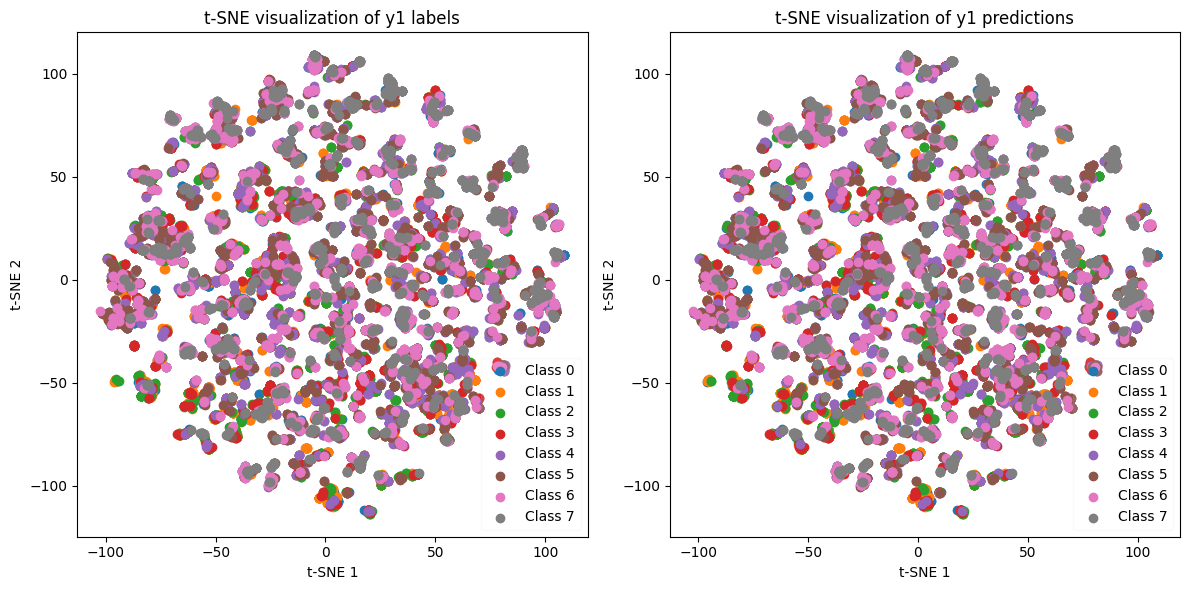

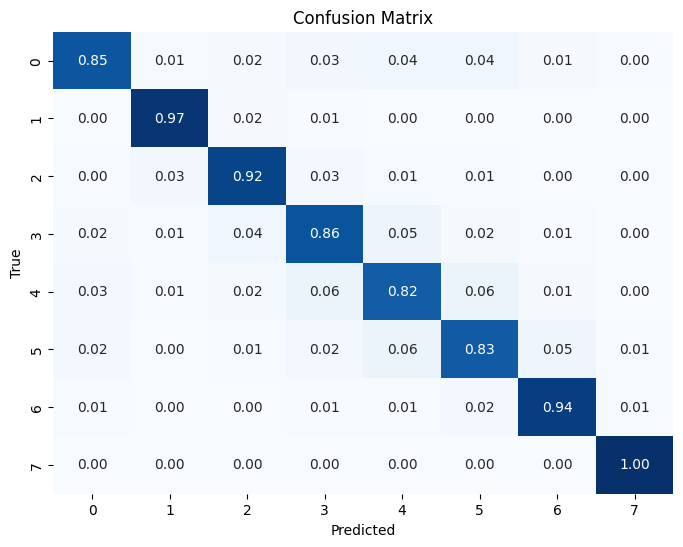

In [28]:
import seaborn as sns
# Define the Hyperparameters
n_estimators = best_params['n_estimators']
max_depth =  best_params['max_depth']
learning_rate = best_params['learning_rate']  #0.07558
max_delta_step = best_params['max_delta_step']
alpha = best_params['alpha']
early_stopping_rounds = 2
subsample = 1
random_state = 42
# random_state = 42


result_filename_csv = "dual_XGB_results_with_seeds.xlsx"
output_location = 'Dual_Path_XGB_with_seeds'

# Directories
os.makedirs(output_location, exist_ok=True)


results = []
classes = list(class_counts_y1.keys())

# Number of trials and seeds per trial
n_trials = 1 # 5
n_seeds_per_trial = 1
total_seeds = n_trials * n_seeds_per_trial

# Generate unique random seeds
# seeds = random.sample(range(1, 10000), total_seeds)
# seeds = [1234]
seeds = [42]

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_index = 0

for trial in range(n_trials):
    for _ in range(n_seeds_per_trial):
        seed = seeds[seed_index]
        seed_index += 1
        set_seed(seed)

        # Initialize dictionaries to store per-class accuracy and e_accuracy
        class_accuracy_y1 = {}
        class_e_accuracy_y1 = {}

        # Convert train_y1 to a 1D array (flatten if necessary)
        train_y1_flat = train_y1.flatten()

        # Check if train_y1_flat is on GPU
        if train_y1_flat.is_cuda:
          train_y1_flat = train_y1_flat.cpu().numpy()  # Move to CPU and convert to numpy
        else:
          train_y1_flat = train_y1_flat.numpy()

        class_weights = compute_class_weight(class_weight='balanced', classes= np.unique(train_y1_flat), y=train_y1_flat)

        # Convert class weights into a dictionary format for later use
        class_weights_dict = {cls: weight for cls, weight in zip(np.unique(train_y1_flat) , class_weights)}
        print(f"Class weights y1 : {class_weights_dict}")
        # Generate sample weights based on class weights
        sample_weights = np.array([class_weights_dict[label] for label in train_y1_flat])

        # Initialize XGBoost model for multi-class classification with verbosity
        tree_method = 'gpu_hist' if torch.cuda.is_available() else 'hist'
        params = {
                'n_estimators' : n_estimators,
                'max_depth' : max_depth,
                'learning_rate': learning_rate,
                'random_state': random_state,
                'n_jobs' : -1,
                'objective' : 'multi:softmax',
                'num_class' : len(np.unique(train_y1_flat) ),
                'verbosity' : 2,
                'eval_metric' : ["mlogloss", "merror", "auc"],
                'early_stopping_rounds' : early_stopping_rounds,
                'tree_method': tree_method,
                # 'device' :'gpu',
                'max_delta_step' : max_delta_step , # it might help in logistic regression when class is extremely imbalanced. Set it to value of 1-10 might help control the update.
                'alpha': alpha, # L1 regularization term on weights. Increasing this value will make model more conservative.
                'subsample': subsample,
        }
        xgb_y1 = xgb.XGBClassifier(**params)

        # Create evaluation sets (optional: you can also include a validation set here)
        eval_set = [(val_data, val_y1)]  # You can add (validation_data, validation_y1) here as well
        # Train the model using the sample weights with verbose monitoring
        xgb_y1.fit(train_data, train_y1, sample_weight=sample_weights, eval_set=eval_set, verbose=True)

        # Saving xgb_y1 model
        joblib.dump(xgb_y1, f'{output_location}/xgb_y1_model_{n_estimators}_MaxDepth_{max_depth}_learning_rate_{learning_rate}_randomstate_{seed}.pkl')

        # Training predictions
        train_y1_pred = xgb_y1.predict(train_data).reshape(-1, 1)
        # Validation predictions
        val_y1_pred = xgb_y1.predict(val_data).reshape(-1, 1)
        # Test predictions
        test_y1_pred = xgb_y1.predict(test_data).reshape(-1, 1)

        # Calculate e_accuracy for the training set
        # Ensure both are tensors
        if isinstance(train_y1_pred, torch.Tensor):
          device = train_y1_pred.device  # Get device if it's already a tensor
        else:
          device = 'cpu'
        #device = train_y1_pred.device if train_y1_pred.is_cuda else 'cpu'
        if isinstance(train_y1_pred, np.ndarray):
          train_y1_pred = torch.tensor(train_y1_pred, device=device)
        if isinstance(train_y1, np.ndarray):
          train_y1 = torch.tensor(train_y1, device=device)
        else:
          train_y1 = train_y1.to(device)
        correct_y1_e_accuracy_train = ((train_y1_pred >= (train_y1 - 1)) & (train_y1_pred <= (train_y1 + 1))).sum().item()
        train_total = train_y1.shape[0]

        e_accuracy_kcat_train = correct_y1_e_accuracy_train / train_total

        # Calculate e_accuracy for the validation set
        if isinstance(val_y1_pred, torch.Tensor):
          device = val_y1_pred.device  # Get device if it's already a tensor
        else:
          device = 'cpu'
        #device = train_y1_pred.device if train_y1_pred.is_cuda else 'cpu'
        if isinstance(val_y1_pred, np.ndarray):
          val_y1_pred = torch.tensor(val_y1_pred, device=device)
        if isinstance(val_y1, np.ndarray):
          val_y1 = torch.tensor(val_y1, device=device)
        else:
          val_y1 = val_y1.to(device)

        correct_y1_e_accuracy_val = ((val_y1_pred >= (val_y1 - 1)) & (val_y1_pred <= (val_y1 + 1))).sum().item()
        val_total = val_y1.shape[0]

        e_accuracy_kcat_val = correct_y1_e_accuracy_val / val_total

        # Calculate e_accuracy for the test set
        if isinstance(test_y1_pred, torch.Tensor):
          device = test_y1_pred.device  # Get device if it's already a tensor
        else:
          device = 'cpu'
        #device = train_y1_pred.device if train_y1_pred.is_cuda else 'cpu'
        if isinstance(test_y1_pred, np.ndarray):
          test_y1_pred = torch.tensor(test_y1_pred, device=device)
        if isinstance(test_y1, np.ndarray):
          test_y1 = torch.tensor(test_y1, device=device)
        else:
          test_y1 = test_y1.to(device)
        correct_y1_e_accuracy_test = ((test_y1_pred >= (test_y1 - 1)) & (test_y1_pred <= (test_y1 + 1))).sum().item()
        test_total = test_y1.shape[0]

        e_accuracy_kcat_test = correct_y1_e_accuracy_test / test_total

        # Calculate other metrics for training data
        accuracy_train_y1 = accuracy_score(train_y1, train_y1_pred)

        precision_train_y1 = precision_score(train_y1, train_y1_pred, average='weighted')
        recall_train_y1 = recall_score(train_y1, train_y1_pred, average='weighted')
        f1_train_y1 = f1_score(train_y1, train_y1_pred, average='weighted')
        mcc_train_y1 = matthews_corrcoef(train_y1, train_y1_pred)

        # Binarize labels for AUC-PR calculationsubsample
        classes = np.unique(train_y1)
        train_y1_true_bin = label_binarize(train_y1, classes=classes)
        train_y1_pred_bin = label_binarize(train_y1_pred, classes=classes)
        auc_pr_train_y1 = average_precision_score(train_y1_true_bin, train_y1_pred_bin, average='weighted')

        # Calculate other metrics for validation data
        accuracy_val_y1 = accuracy_score(val_y1, val_y1_pred)

        precision_val_y1 = precision_score(val_y1, val_y1_pred, average='weighted')
        recall_val_y1 = recall_score(val_y1, val_y1_pred, average='weighted')
        f1_val_y1 = f1_score(val_y1, val_y1_pred, average='weighted')
        mcc_val_y1 = matthews_corrcoef(val_y1, val_y1_pred)

        # Binarize labels for AUC-PR calculation
        val_y1_true_bin = label_binarize(val_y1, classes=classes)
        val_y1_pred_bin = label_binarize(val_y1_pred, classes=classes)
        auc_pr_val_y1 = average_precision_score(val_y1_true_bin, val_y1_pred_bin, average='weighted')

        # Calculate other metrics for test data
        accuracy_test_y1 = accuracy_score(test_y1, test_y1_pred)
        # Calculate confusion matrix
        conf_matrix_test_y1 = confusion_matrix(test_y1, test_y1_pred)
        # Normalize the confusion matrix to display per-class accuracies
        class_totals_test_y1 = conf_matrix_test_y1.sum(axis=1)
        conf_matrix_test_y1_normalized = conf_matrix_test_y1.astype('float') / class_totals_test_y1[:, np.newaxis]
        # Calculate per-class accuracies (diagonal of the normalized confusion matrix)
        per_class_accuracy_test_y1 = np.diag(conf_matrix_test_y1_normalized)

        precision_test_y1 = precision_score(test_y1, test_y1_pred, average='weighted')
        recall_test_y1 = recall_score(test_y1, test_y1_pred, average='weighted')
        f1_test_y1 = f1_score(test_y1, test_y1_pred, average='weighted')
        mcc_test_y1 = matthews_corrcoef(test_y1, test_y1_pred)

        # Binarize labels for AUC-PR calculation
        test_y1_true_bin = label_binarize(test_y1, classes=classes)
        test_y1_pred_bin = label_binarize(test_y1_pred, classes=classes)
        auc_pr_test_y1 = average_precision_score(test_y1_true_bin, test_y1_pred_bin, average='weighted')

        # Loop through each class to calculate per-class accuracy and e_accuracy
        for cls in classes:
            # Indices where the true label is equal to the current class
            class_indices = np.where(test_y1 == cls)[0]

            # True and predicted labels for the current class
            true_class_labels = test_y1[class_indices]
            pred_class_labels = test_y1_pred[class_indices]

            # Calculate per-class accuracy
            accuracy_cls = accuracy_score(true_class_labels, pred_class_labels)
            class_accuracy_y1[cls] = accuracy_cls

            # Calculate per-class e_accuracy (within ±1 of true label)
            correct_e_accuracy_cls = ((pred_class_labels >= (true_class_labels - 1)) & (pred_class_labels <= (true_class_labels + 1))).sum()
            e_accuracy_cls = correct_e_accuracy_cls / len(true_class_labels)
            class_e_accuracy_y1[cls] = e_accuracy_cls

        # Print per-class accuracy
        print("\nPer-class Accuracy (kcat):")
        for class_id, accuracy in class_accuracy_y1.items():
            print(f"Class {class_id}: Accuracy = {accuracy:.4f}")

        # Print per-class e_accuracy
        print("\nPer-class e-Accuracy (kcat):")
        for class_id, e_accuracy in class_e_accuracy_y1.items():
            print(f"Class {class_id}: e-Accuracy = {e_accuracy:.4f}")

       # Store results in the expected structure
        # results = []

        avg_train_acc = accuracy_train_y1
        avg_val_acc = accuracy_val_y1
        avg_test_acc = accuracy_test_y1

        # print(f'Test Accuracy: {test_accuracy_y1:.4f}')
        print(f"Train Accuracy: {avg_train_acc:.2f}, Validation Accuracy: {avg_val_acc:.2f}, Test Accuracy: {avg_test_acc:.2f} ")

        results.append({
            "Name": "XGBoost",
            "n_estimators": f"{n_estimators}",
            "max_depth": f"{max_depth}",
            "learning rate": f"{learning_rate:.8f}",
            "Train acc (Kcat)": f"{accuracy_train_y1:.6f}",
            "Avg Train acc": f"{avg_train_acc:.6f}",
            "Val acc (Kcat)": f"{accuracy_val_y1:.6f}",
            "Avg Val acc": f"{avg_val_acc:.6f}",
            "Test acc (Kcat)": f"{accuracy_test_y1:.6f}",
            "Avg Test acc": f"{avg_test_acc:.6f}",
            "Train e_Accuracy (Kcat)": f"{e_accuracy_kcat_train:.6f}",
            "Val e_Accuracy (Kcat)": f"{e_accuracy_kcat_val:.6f}",
            "Test e_Accuracy (Kcat)": f"{e_accuracy_kcat_test:.6f}",
            "Precision (Kcat) - Train": f"{precision_train_y1:.4f}",
            "Recall (Kcat) - Train": f"{recall_train_y1:.4f}",
            "F1-Score (Kcat) - Train": f"{f1_train_y1:.4f}",
            "MCC (Kcat) - Train": f"{mcc_train_y1:.4f}",
            "AUC-PR (Kcat) - Train": f"{auc_pr_train_y1:.4f}",
            "Precision (Kcat) - Val": f"{precision_val_y1:.4f}",
            "Recall (Kcat) - Val": f"{recall_val_y1:.4f}",
            "F1-Score (Kcat) - Val": f"{f1_val_y1:.4f}",
            "MCC (Kcat) - Val": f"{mcc_val_y1:.4f}",
            "AUC-PR (Kcat) - Val": f"{auc_pr_val_y1:.4f}",
            "Precision (Kcat) - Test": f"{precision_test_y1:.4f}",
            "Recall (Kcat) - Test": f"{recall_test_y1:.4f}",
            "F1-Score (Kcat) - Test": f"{f1_test_y1:.4f}",
            "MCC (Kcat) - Test": f"{mcc_test_y1:.4f}",
            "AUC-PR (Kcat) - Test": f"{auc_pr_test_y1:.4f}",
            "Ramdom-state" : f"{seed}"
        })

        # t-SNE Visualization
        y1_preds = np.array(test_y1_pred).reshape(-1, 1)
        y1_labels = np.array(test_y1).reshape(-1, 1)


        if isinstance(test_data, torch.Tensor):
          test_data = test_data.cpu().numpy()

        tsne = TSNE(n_components=2, random_state=42)
        test_tsne = tsne.fit_transform(test_data)

        # output_size1 = len(np.unique(test_y1))

        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        for i in range(output_size1):
            indices = np.where(y1_labels == i)
            plt.scatter(test_tsne[indices, 0], test_tsne[indices, 1], label=f'Class {i}')
        plt.title('t-SNE visualization of y1 labels')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.legend(loc='best', framealpha=0.1)

        plt.subplot(1, 2, 2)
        for i in range(output_size1):
            indices = np.where(y1_preds == i)
            plt.scatter(test_tsne[indices, 0], test_tsne[indices, 1], label=f'Class {i}')
        plt.title('t-SNE visualization of y1 predictions')
        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.legend(loc='best', framealpha=0.1)

        plt.tight_layout()
        # img_name = f"{output_location}/Dual_TSNE-xgb_n_estimators_{n_estimators}_MaxDepth_{max_depth}_learning_rate_{learning_rate}_randomstate_{seed}_test.png"
        # plt.savefig(img_name)

        # Plot confusion matrix using seaborn heatmap
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_matrix_test_y1_normalized, annot=True, fmt='.2f', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')

        # Display the plot
        plt.show()

# Create a DataFrame with the results and display it
results_df = pd.DataFrame(results)
results_df_T = results_df.T
# Set the column names as the first column of the transposed dataframe
results_df_T.insert(0, 'Header', results_df.columns)
# Optionally, reset the index if needed
results_df_T.reset_index(drop=True, inplace=True)
# results_df.to_excel(result_filename_csv, index=False)
# Function to add a new column to existing excel file or save a new one if the file doesn't exist
def save_or_update_excel(results_df, result_filename_excel):
    try:
        # Try to open the existing file
        existing_df = pd.read_excel(result_filename_excel, header=None)
        # If file exists, concatenate the new column
        updated_df = pd.concat([existing_df, results_df], axis=1)
        # updated_df = updated_df
        # Write the updated dataframe back to the excel file
        updated_df.to_excel(result_filename_excel, index=False)
    except FileNotFoundError:
        # If file doesn't exist, write a new file
        results_df_T.to_excel(result_filename_excel, index=False)
# Transpose the results_df and write to excel (or update if it already exists)
save_or_update_excel(results_df_T, result_filename_csv)

In [45]:
# Save the model to a pickle file
with open('xgb_y1_model.pkl', 'wb') as file:
    pickle.dump(xgb_y1, file)

In [29]:
import pickle

# Assuming test_y1, test_y1_pred, and classes are already defined in your session
data_to_save = {
    'test_data_X1' : test_data,
    'test_y1': test_y1,
    'test_y1_pred': test_y1_pred,
    'classes': classes,
    'global_mean_1': global_mean_1,
    'global_std_1': global_std_1,
    'global_mean_2': global_mean_2,
    'global_std_2': global_std_2
}

# Save the data as a pickle file
with open('test_data_predictions_XGB_kcat.pkl', 'wb') as file:
    pickle.dump(data_to_save, file)

print("Data saved to 'test_data_predictions_XGB_kcat.pkl'")


Data saved to 'test_data_predictions_XGB_kcat.pkl'


In [30]:

# Print per-class accuracy and e_accuracy
print("\nPer-class Accuracy (kcat):")
for class_id, accuracy in class_accuracy_y1.items():
    print(f"Class {class_id}: Accuracy = {accuracy:.4f}")

print("\nPer-class e-Accuracy (kcat):")
for class_id, e_accuracy in class_e_accuracy_y1.items():
    print(f"Class {class_id}: e-Accuracy = {e_accuracy:.4f}")


Per-class Accuracy (kcat):
Class 0: Accuracy = 0.8519
Class 1: Accuracy = 0.9734
Class 2: Accuracy = 0.9191
Class 3: Accuracy = 0.8569
Class 4: Accuracy = 0.8218
Class 5: Accuracy = 0.8318
Class 6: Accuracy = 0.9411
Class 7: Accuracy = 0.9964

Per-class e-Accuracy (kcat):
Class 0: e-Accuracy = 0.8615
Class 1: e-Accuracy = 0.9915
Class 2: e-Accuracy = 0.9726
Class 3: e-Accuracy = 0.9463
Class 4: e-Accuracy = 0.9366
Class 5: e-Accuracy = 0.9397
Class 6: e-Accuracy = 0.9738
Class 7: e-Accuracy = 0.9976


In [31]:
results_df_T

,Header,0
0,Name,XGBoost
1,n_estimators,318
2,max_depth,50
3,learning rate,0.07534933
4,Train acc (Kcat),0.999862
5,Avg Train acc,0.999862
6,Val acc (Kcat),0.887728
7,Avg Val acc,0.887728
8,Test acc (Kcat),0.898608
9,Avg Test acc,0.898608


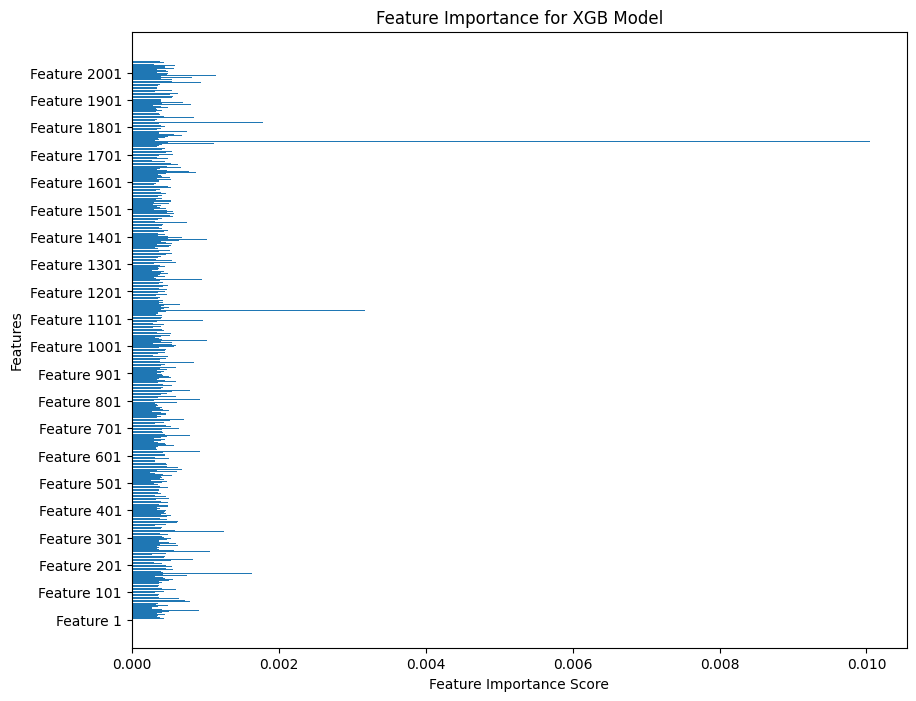

In [32]:
# Get the feature importance scores
importance_scores = xgb_y1.feature_importances_
# importance_scores
import matplotlib.pyplot as plt

# Generate feature names from 1 to the number of importance scores
feature_names = [f'Feature {i+1}' for i in range(len(importance_scores))]

# Plotting without sorting
plt.figure(figsize=(10, 8))
plt.barh(feature_names, importance_scores)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Feature Importance for XGB Model')

# Show fewer y-ticks by displaying every nth tick
step = 100  # Adjust the step to control the interval of displayed ticks
plt.yticks(ticks=np.arange(0, len(feature_names), step), labels=feature_names[::step])

plt.show()


## Check with CatAware Test Set

In [33]:
%%skip
# Function to select data from a custom TensorDataset based on given indices
def select_indices_from_dataset(dataset, indices):
    """
    Selects data from a custom TensorDataset based on given indices.

    Parameters:
    - dataset: A TensorDataset object (custom).
    - indices: A list of indices to select data from the dataset.

    Returns:
    - A new TensorDataset object with only the selected data and labels.
    """
    selected_data = [dataset[i] for i in indices]  # Extract data based on indices
    data_tensors, data_labels = zip(*selected_data)  # Split data and labels
    # print(list(data_tensors))
    # Convert tuples to PyTorch tensors
    data_tensors = torch.stack(data_tensors)  # Stack tensors from the list of data tensors
    data_labels = torch.tensor(data_labels)   # Convert labels to a tensor
    return TensorDataset(data_tensors, data_labels)  # Return new dataset


val_test_ind = [11, 16, 17, 26, 29, 36, 37, 44, 50, 10, 15, 22, 32, 34, 43]

# Assuming testCatAware_WT_dataset_org and testCatAware_MD_dataset_org are the datasets
testCatAware_WT_dataset_org = select_indices_from_dataset(testCatAware_WT_dataset_org, val_test_ind)
testCatAware_MD_dataset_org = select_indices_from_dataset(testCatAware_MD_dataset_org, val_test_ind)



In [34]:
# Apply standardization to the test tensors using train_mean_data and train_std_data
testCatAware_WT_dataset_std = apply_global_standardization_separate(testCatAware_WT_dataset_org, global_mean_1, global_std_1, global_mean_2, global_std_2)
testCatAware_MD_dataset_std = apply_global_standardization_separate(testCatAware_MD_dataset_org, global_mean_1, global_std_1, global_mean_2, global_std_2)  # Use train stats

get_val_test_stats_separate(testCatAware_WT_dataset_std, "Test_CatAware_WT")
get_val_test_stats_separate(testCatAware_MD_dataset_std, "Test_CatAware_MD")

X_CatAware_WT_test_data, test_CatAware_WT_y1 = dataset_to_tensors_separate(testCatAware_WT_dataset_std)
X_CatAware_MD_test_data, test_CatAware_MD_y1 = dataset_to_tensors_separate(testCatAware_MD_dataset_std)

X_CatAware_WT_test_data = X_CatAware_WT_test_data.cpu().numpy()
test_CatAware_WT_y1 = test_CatAware_WT_y1.cpu().numpy()#.reshape(-1, 1)
X_CatAware_MD_test_data = X_CatAware_MD_test_data.cpu().numpy()
test_CatAware_MD_y1 = test_CatAware_MD_y1.cpu().numpy()#.reshape(-1, 1)



After Global Standardization (Test_CatAware_WT Dataset):
X1 Mean: 0.00016129900177475065, X1 Std: 1.0218660831451416
X2 Mean: 0.0023906128481030464, X2 Std: 3.4195568561553955

After Global Standardization (Test_CatAware_MD Dataset):
X1 Mean: 0.00011758097389247268, X1 Std: 1.0268666744232178
X2 Mean: 0.0023906128481030464, X2 Std: 3.4195568561553955


Accuracy for test_data_NoSMOTE set: 0.950244335850733


<ipython-input-35-c5b4c575403b>:24: RuntimeWarning: invalid value encountered in divide
  conf_matrix_test_y1_normalized_NoSMOTE = conf_matrix_test_y1_NoSMOTE.astype('float') / class_totals_test_y1_NoSMOTE[:, np.newaxis]


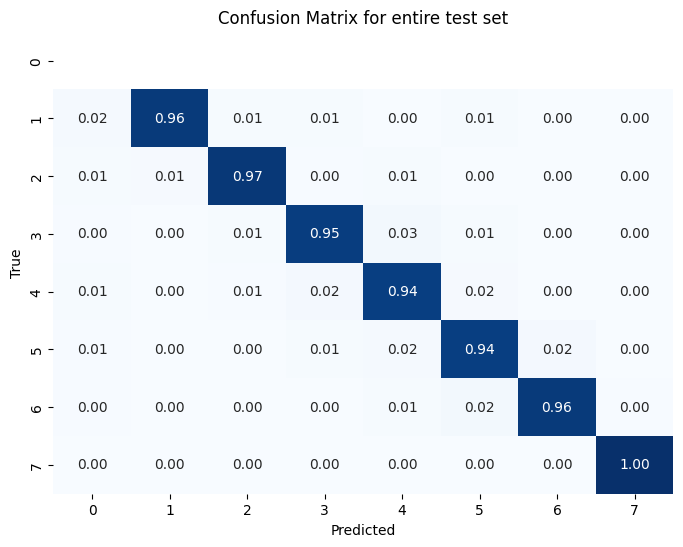

In [35]:

test_dataset_NoSMOTE = apply_global_standardization_separate(test_dataset_NoSMOTE_org, global_mean_1, global_std_1, global_mean_2, global_std_2)  # Use train stats
# Check stats for validation and test datasets after standardization
# get_val_test_stats_separate(test_dataset_NoSMOTE, "Test_NoSMOTE")
test_data_NoSMOTE, test_y1_NoSMOTE = dataset_to_tensors_separate(test_dataset_NoSMOTE)

# Save the tensors
torch.save((test_data_NoSMOTE, test_y1_NoSMOTE), f'{save_dir}/test_dataset_NoSMOTE_std_kcat.pt')

test_data_NoSMOTE, test_y1_NoSMOTE = test_data_NoSMOTE.cpu().numpy(), test_y1_NoSMOTE.cpu().numpy()+1


# Predict y1 for test_data_NoSMOTE
test_y1_pred_NoSMOTE = xgb_y1.predict(test_data_NoSMOTE)#.reshape(-1, 1)
# test_y1_pred_NoSMOTE = ensemble_model.predict(test_data_NoSMOTE)#.reshape(-1, 1)
# Compare the predicted y1 with the actual test_y1_NoSMOTE_tensor
comparison_test_data_NoSMOTE = (test_y1_pred_NoSMOTE == test_y1_NoSMOTE)
accuracy_test_data_NoSMOTE = comparison_test_data_NoSMOTE.sum().item() / len(test_y1_NoSMOTE)
print(f"Accuracy for test_data_NoSMOTE set: {accuracy_test_data_NoSMOTE}")

# Calculate confusion matrix
conf_matrix_test_y1_NoSMOTE = confusion_matrix(test_y1_NoSMOTE, test_y1_pred_NoSMOTE)
# Normalize the confusion matrix to display per-class accuracies
class_totals_test_y1_NoSMOTE = conf_matrix_test_y1_NoSMOTE.sum(axis=1)
conf_matrix_test_y1_normalized_NoSMOTE = conf_matrix_test_y1_NoSMOTE.astype('float') / class_totals_test_y1_NoSMOTE[:, np.newaxis]
# Calculate per-class accuracies (diagonal of the normalized confusion matrix)
per_class_accuracy_test_y1_NoSMOTE = np.diag(conf_matrix_test_y1_normalized_NoSMOTE)

#  Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix_test_y1_normalized_NoSMOTE, annot=True, fmt='.2f', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for entire test set')

# Display the plot
plt.show()

In [36]:
# Predict y1 for X_CatAware_WT_test_data
y1_testset_WT_pred_label = xgb_y1.predict(X_CatAware_WT_test_data)#.reshape(-1, 1)
# Compare the predicted y1 with the actual y1_test_WT_tensor
comparison_WT = (y1_testset_WT_pred_label == test_CatAware_WT_y1)
accuracy_WT = comparison_WT.sum().item() / len(test_CatAware_WT_y1)
print(f"Accuracy for WT test set: {accuracy_WT}")


# Predict y1 for X_CatAware_MD_test_data
y1_testset_MD_pred_label = xgb_y1.predict(X_CatAware_MD_test_data)#.reshape(-1, 1)

# Compare the predicted y1 with the actual y1_test_WT_tensor
comparison_MD = (y1_testset_MD_pred_label == test_CatAware_MD_y1)
accuracy_MD = comparison_MD.sum().item() / len(test_CatAware_MD_y1)
print(f"Accuracy for MD test set: {accuracy_MD}")


Accuracy for WT test set: 0.9629629629629629
Accuracy for MD test set: 0.8518518518518519


Number of cases where predicted WT is equal to True class WT: 52


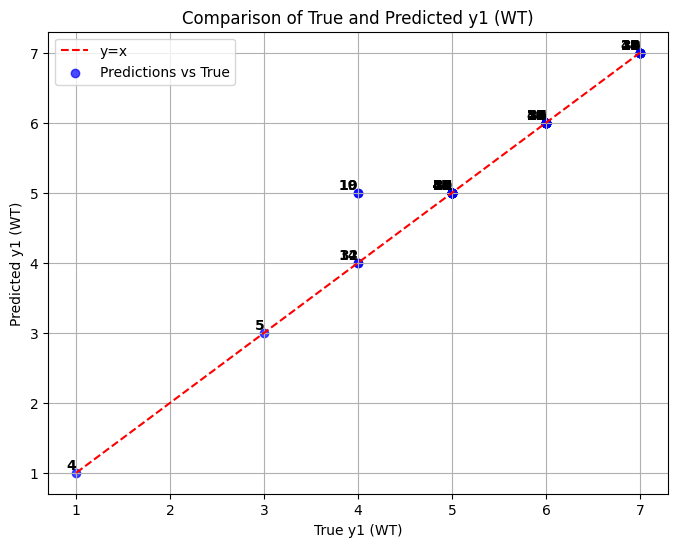

,True y1 (WT),Predicted y1 (WT),pred_equals_true
0,6,6,True
1,5,5,True
2,6,6,True
3,6,6,True
4,1,1,True
5,3,3,True
6,6,6,True
7,6,6,True
8,7,7,True
9,7,7,True


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the arrays are already available as numpy arrays
y1_testset_WT_pred_np = y1_testset_WT_pred_label
test_CatAware_WT_y1_np = test_CatAware_WT_y1

# Creating a dataframe to compare predicted and true values
comparison_df = pd.DataFrame({
    'True y1 (WT)': test_CatAware_WT_y1_np,
    'Predicted y1 (WT)': y1_testset_WT_pred_np
})

# Adding a column to indicate where MD predictions are lower than WT predictions
comparison_df['pred_equals_true'] = comparison_df['True y1 (WT)'] == comparison_df['Predicted y1 (WT)']

# Counting the number of cases where MD is lower than WT
count_pred_equals_true = comparison_df['pred_equals_true'].sum()

# Display the count
print(f"Number of cases where predicted WT is equal to True class WT: {count_pred_equals_true}")

# Plotting y=x line and comparison scatter plot
plt.figure(figsize=(8, 6))
plt.plot([min(test_CatAware_WT_y1_np), max(test_CatAware_WT_y1_np)],
         [min(test_CatAware_WT_y1_np), max(test_CatAware_WT_y1_np)],
         label='y=x', color='red', linestyle='--')

plt.scatter(test_CatAware_WT_y1_np, y1_testset_WT_pred_np, color='blue', alpha=0.7, label='Predictions vs True')

# Label each point with its index
for i, (true_y1_test, wt_pred) in enumerate(zip(test_CatAware_WT_y1_np, y1_testset_WT_pred_np)):
    plt.text(true_y1_test, wt_pred, str(i), fontsize=10, ha='right', va='bottom', color='black', weight='bold')

plt.xlabel('True y1 (WT)')
plt.ylabel('Predicted y1 (WT)')
plt.title('Comparison of True and Predicted y1 (WT)')
plt.legend()
plt.grid(True)
plt.show()

comparison_df

Number of cases where predicted MD is lower than predicted WT: 7
Number of cases where predicted MD is lower than predicted WT and WT predicted True Value: 6


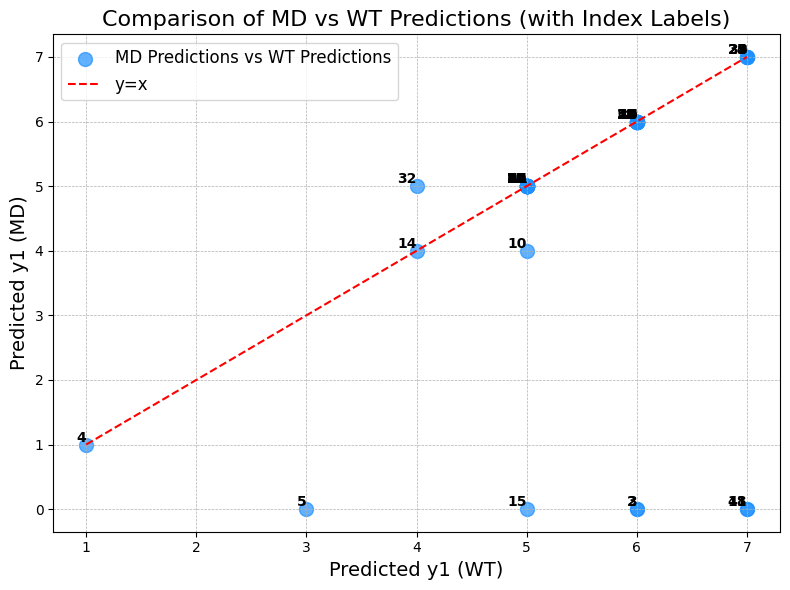

,True y1 (WT),Predicted y1 (WT),Predicted y1 (MD),MD_lower_than_WT,MD_lower_than_WT_andTruePred
0,6,6,6,False,False
1,5,5,5,False,False
2,6,6,0,True,True
3,6,6,0,True,True
4,1,1,1,False,False
5,3,3,0,True,True
6,6,6,6,False,False
7,6,6,6,False,False
8,7,7,7,False,False
9,7,7,7,False,False


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming the arrays are already available as numpy arrays
y1_testset_MD_pred_np = y1_testset_MD_pred_label#.cpu().numpy()
test_CatAware_MD_y1_np = test_CatAware_MD_y1#.cpu().numpy()

# Creating a dataframe to compare predicted and true values
comparison_df_MD = pd.DataFrame({
    'True y1 (WT)': test_CatAware_WT_y1_np,
    'Predicted y1 (WT)': y1_testset_WT_pred_np,
    'Predicted y1 (MD)': y1_testset_MD_pred_np
})

# Adding a column to indicate where MD predictions are lower than WT predictions
comparison_df_MD['MD_lower_than_WT'] = comparison_df_MD['Predicted y1 (MD)'] < comparison_df_MD['Predicted y1 (WT)']
comparison_df_MD['MD_lower_than_WT_andTruePred'] = (
    (comparison_df_MD['Predicted y1 (MD)'] < comparison_df_MD['Predicted y1 (WT)']) &
    (comparison_df_MD['True y1 (WT)'] == comparison_df_MD['Predicted y1 (WT)'])
)

# Counting the number of cases where MD is lower than WT
count_MD_lower_than_WT = comparison_df_MD['MD_lower_than_WT'].sum()
count_MD_lower_than_WT_andTruePred = comparison_df_MD['MD_lower_than_WT_andTruePred'].sum()

# Display the count
print(f"Number of cases where predicted MD is lower than predicted WT: {count_MD_lower_than_WT}")
print(f"Number of cases where predicted MD is lower than predicted WT and WT predicted True Value: {count_MD_lower_than_WT_andTruePred}")


plt.figure(figsize=(8, 6))

# Scatter plot of MD vs WT predictions
plt.scatter(y1_testset_WT_pred_np, y1_testset_MD_pred_np, color='dodgerblue', alpha=0.7, s=100, label='MD Predictions vs WT Predictions')

# Label each point with its index
for i, (wt_pred, md_pred) in enumerate(zip(y1_testset_WT_pred_np, y1_testset_MD_pred_np)):
    plt.text(wt_pred, md_pred, str(i), fontsize=10, ha='right', va='bottom', color='black', weight='bold')

# Plot y=x line for reference
plt.plot([min(y1_testset_WT_pred_np), max(y1_testset_WT_pred_np)],
         [min(y1_testset_WT_pred_np), max(y1_testset_WT_pred_np)],
         label='y=x', color='red', linestyle='--')

# Customize labels and title
plt.xlabel('Predicted y1 (WT)', fontsize=14)
plt.ylabel('Predicted y1 (MD)', fontsize=14)
plt.title('Comparison of MD vs WT Predictions (with Index Labels)', fontsize=16)

# Customize legend and grid
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


# # Plotting y=x line and comparison scatter plot
# plt.figure(figsize=(8, 6))
# plt.plot([min(test_CatAware_WT_y1_np), max(test_CatAware_WT_y1_np)],
#          [min(test_CatAware_WT_y1_np), max(test_CatAware_WT_y1_np)],
#          label='y=x', color='red', linestyle='--')

# plt.scatter(y1_testset_WT_pred_np, y1_testset_MD_pred_np, color='blue', alpha=0.7, label='MD Predictions vs MD Predictions')

# plt.xlabel('WT Predictions y1')
# plt.ylabel('MD Predictions y1')
# plt.title('Comparison of MD Predictions and WT Predictions [y1]')
# plt.legend()
# plt.grid(True)
# plt.show()

comparison_df_MD

In [39]:
# Get the indices where the 'MD_lower_than_WT' column has a True value
true_indices = comparison_df_MD[comparison_df_MD['MD_lower_than_WT'] == True].index

# Convert to a list if you need it in list format
true_indices_list = true_indices.tolist()

# Display the indices
print(true_indices_list)
# [2, 3, 5, 10, 15, 18, 19, 41]


[2, 3, 5, 10, 15, 18, 41]


## Check wit PafA Dataset

In [40]:
#  Apply standardization to the test tensors using train_mean_data and train_std_data
PafA_dataset_std = apply_global_standardization_separate(PafA_dataset_org, global_mean_1, global_std_1, global_mean_2, global_std_2)
get_val_test_stats_separate(PafA_dataset_std, "PafA_Dataset")
X_PafA_test_data, PafA_test_y1 = dataset_to_tensors_separate(PafA_dataset_std)
X_PafA_test_data = X_PafA_test_data.cpu().numpy()
PafA_test_y1 = PafA_test_y1.cpu().numpy()  # -  1   #.reshape(-1, 1)



After Global Standardization (PafA_Dataset Dataset):
X1 Mean: -0.00025930555420927703, X1 Std: 0.982204258441925
X2 Mean: 0.00370826106518507, X2 Std: 2.5256617069244385


In [41]:
# Predict y1 for X_CatAware_WT_test_data
y1_PafA_pred_label = xgb_y1.predict(X_PafA_test_data)#.reshape(-1, 1)
# Compare the predicted y1 with the actual y1_test_WT_tensor
comparison_test_PafA = (y1_PafA_pred_label == PafA_test_y1)
accuracy_test_PafA = comparison_test_PafA.sum().item() / len(PafA_test_y1)
print(f"Accuracy for PafA test set: {accuracy_test_PafA}")

# Calculate e_accuracy: predictions within ±1 of the actual labels
comparison_test_PafA_2 = (np.abs(y1_PafA_pred_label - PafA_test_y1) <= 1)
e_accuracy = comparison_test_PafA_2.sum().item() / len(PafA_test_y1)

print(f"e_Accuracy for PafA test set (within ±1 of true label): {e_accuracy}")

Accuracy for PafA test set: 0.5225806451612903
e_Accuracy for PafA test set (within ±1 of true label): 0.964516129032258


Number of cases where predicted PafA Dataset is equal to True class PafA Dataset: 162


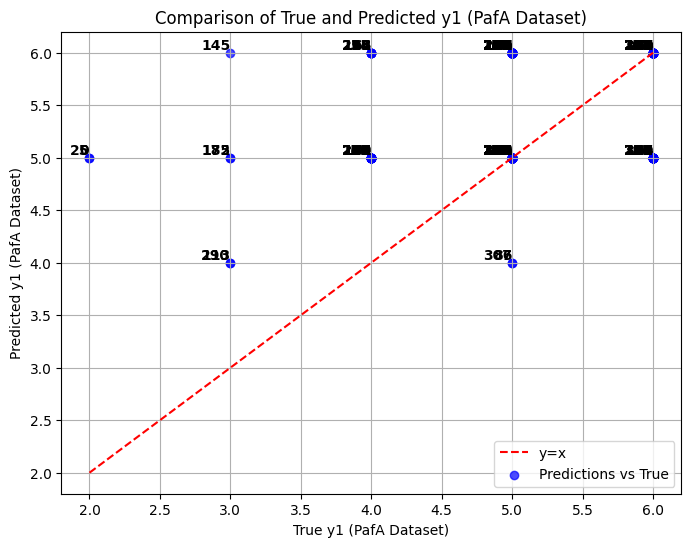

,True y1 (PafA),Predicted y1 (PafA),pred_equals_true
0,2,5,False
1,5,5,True
2,4,5,False
3,6,6,True
4,6,6,True
...,...,...,...
305,6,5,False
306,6,5,False
307,5,4,False
308,6,6,True


In [42]:


# Creating a dataframe to compare predicted and true values
comparison_df_PafA = pd.DataFrame({
    'True y1 (PafA)': PafA_test_y1,
    'Predicted y1 (PafA)': y1_PafA_pred_label
})

# Adding a column to indicate where predictions are equal to the true PafA classes
comparison_df_PafA['pred_equals_true'] = comparison_df_PafA['True y1 (PafA)'] == comparison_df_PafA['Predicted y1 (PafA)']

# Counting the number of cases where where predictions are equal to the true PafA classes
count_pred_equals_true_PafA = comparison_df_PafA['pred_equals_true'].sum()

# Display the count
print(f"Number of cases where predicted PafA Dataset is equal to True class PafA Dataset: {count_pred_equals_true_PafA}")

# Plotting y=x line and comparison scatter plot
plt.figure(figsize=(8, 6))
plt.plot([min(PafA_test_y1), max(PafA_test_y1)],
         [min(PafA_test_y1), max(PafA_test_y1)],
         label='y=x', color='red', linestyle='--')

plt.scatter(PafA_test_y1, y1_PafA_pred_label, color='blue', alpha=0.7, label='Predictions vs True')

# Label each point with its index
for i, (true_y1_test, pt_pred) in enumerate(zip(PafA_test_y1, y1_PafA_pred_label )):
    plt.text(true_y1_test, pt_pred, str(i), fontsize=10, ha='right', va='bottom', color='black', weight='bold')

plt.xlabel('True y1 (PafA Dataset)')
plt.ylabel('Predicted y1 (PafA Dataset)')
plt.title('Comparison of True and Predicted y1 (PafA Dataset)')
plt.legend()
plt.grid(True)
plt.show()

comparison_df_PafA

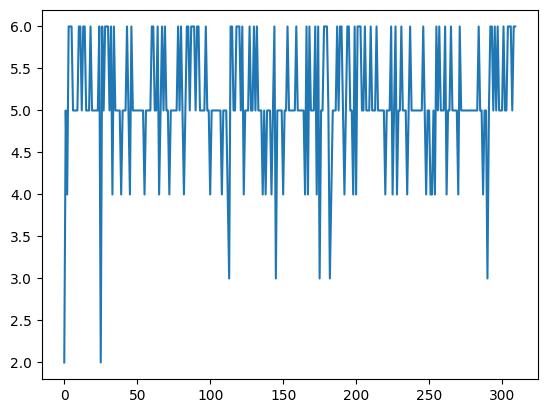

In [43]:
plt.plot(PafA_test_y1)

In [44]:
val_positions = torch.load(f'{save_dir}/PafA_1_val_positions_2.pt')
test_positions = torch.load(f'{save_dir}/PafA_1_test_positions_2.pt')
combined_positions = torch.load(f'{save_dir}/PafA_1_val_test_positions_2.pt')

# Load the validation kcat and km
val_kcat, val_km = torch.load(f'{save_dir}/PafA_1_val_kcat_km_2.pt')
# Load the test kcat and km
test_kcat, test_km = torch.load(f'{save_dir}/PafA_1_test_kcat_km_2.pt')
# Load the combined validation and test kcat and km
combined_kcat, combined_km = torch.load(f'{save_dir}/PafA_1_val_test_kcat_km_2.pt')



# Define a function to map predicted bin integers to the bin ranges
def get_bin_range(predicted_bins, bin_stats_df):
    bin_ranges = []
    for bin_idx in predicted_bins:
        # Get the corresponding min and max values for the predicted bin
        bin_range = bin_stats_df.loc[bin_stats_df['auto_log_bin'] == bin_idx, ['min', 'max']].values[0]
        bin_ranges.append(bin_range)
    return bin_ranges

# Load the variables from the pickle file
input_path = './data_split_WithImp_save_NoResamp_10b/Save_kinetic_bin_range.pkl'
with open(input_path, 'rb') as f:
    data = pickle.load(f)

kcat_auto_log_bin_stats = data['kcat_auto_log_bin_stats']
print('Loaded kcat_auto_log_bin_stats successfully')

# Function to round values to the nearest power of 10, handling zero values
def round_to_nearest_power_of_10(value):
    if value == 0:
        return 10 ** round(-9)  # Keep zero as is
    else:
        return 10 ** round(np.log10(value))

# Apply rounding to 'min' and 'max' columns
kcat_auto_log_bin_stats['min'] = kcat_auto_log_bin_stats['min'].apply(round_to_nearest_power_of_10)
kcat_auto_log_bin_stats['max'] = kcat_auto_log_bin_stats['max'].apply(round_to_nearest_power_of_10)

<ipython-input-44-b18cfac0a2b1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  val_positions = torch.load(f'{save_dir}/PafA_1_val_positions_2.pt')


FileNotFoundError: [Errno 2] No such file or directory: '/content//PafA_1_val_positions_2.pt'

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


Length of test_positions: 310
Length of experimental_kcat: 310
Position 164 is found at indices: [123, 200]


findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not fo

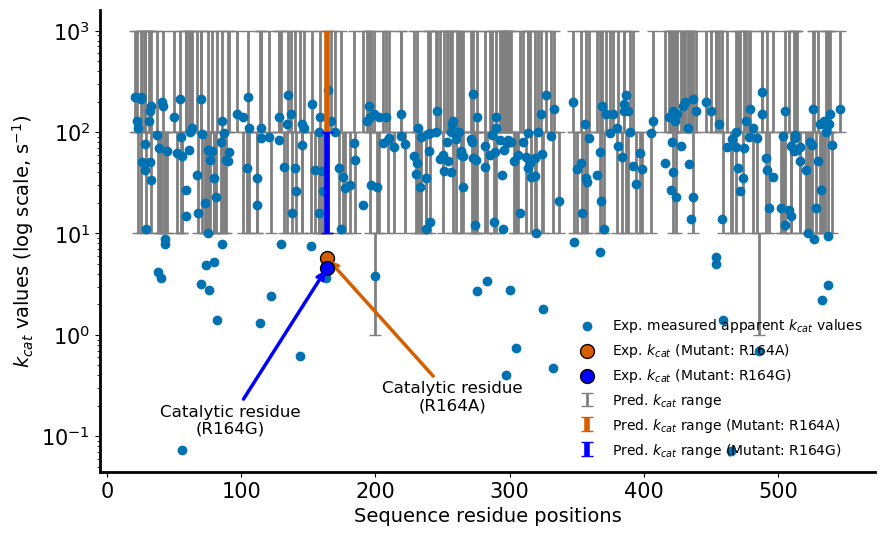

In [ ]:
import matplotlib.pyplot as plt

# Filter indices where predicted labels match the test labels
# match_indices = [i for i, (pred, true) in enumerate(zip(y1_PafA_pred_label, PafA_test_y1)) if pred == true]
match_indices = [i for i, (pred, true) in enumerate(zip(y1_PafA_pred_label, y1_PafA_pred_label)) if pred == true]


experimental_kcat = test_kcat.tolist()  # Experimental kcat values
positions = test_positions.tolist()

# Check the sizes of test_positions and experimental_kcat
print("Length of test_positions:", len(test_positions))
print("Length of experimental_kcat:", len(experimental_kcat))

# Map the predicted bins for KinDL_pred to their respective rounded ranges
kindl_pred_bins = y1_PafA_pred_label
predicted_kcat_bins = get_bin_range(kindl_pred_bins, kcat_auto_log_bin_stats)

# Extract min and max values from predicted bins
predicted_kcat_min = [pred[0] for pred in predicted_kcat_bins]
predicted_kcat_max = [pred[1] for pred in predicted_kcat_bins]
predicted_kcat_mid = [(pred[0] + pred[1]) / 2 for pred in predicted_kcat_bins]  # Midpoint for scatter
# predicted_kcat_mid = [np.sqrt(pred[0]*pred[1]) for pred in predicted_kcat_bins]  # Midpoint for scatter


# Filter positions, experimental kcat, and predicted kcat bins based on match_indices
filtered_positions = [positions[i] for i in match_indices]
filtered_experimental_kcat = [experimental_kcat[i] for i in match_indices]
filtered_predicted_kcat_min = [predicted_kcat_min[i] for i in match_indices]
filtered_predicted_kcat_max = [predicted_kcat_max[i] for i in match_indices]
filtered_predicted_kcat_mid = [predicted_kcat_mid[i] for i in match_indices]

# Calculate the upper and lower errors based on the filtered predicted range
filtered_lower_errors = [mid - min_val for min_val, mid in zip(filtered_predicted_kcat_min, filtered_predicted_kcat_mid)]
filtered_upper_errors = [max_val - mid for max_val, mid in zip(filtered_predicted_kcat_max, filtered_predicted_kcat_mid)]
filtered_yerr = [filtered_lower_errors, filtered_upper_errors]  # This is now in the correct (2, n) shape

# #  Identify and separate data for position 164 in the original positions
# highlight_position = 164
# highlight_index = positions.index(highlight_position) if highlight_position in positions else None


# Identify all indices where position 164 occurs in the list
highlight_position = 164
highlight_indices = [i for i, pos in enumerate(positions) if pos == highlight_position]

# Print the result
if highlight_indices:
    print(f"Position {highlight_position} is found at indices: {highlight_indices}")
else:
    print(f"Position {highlight_position} is not in the positions list.")

# Mapping of specific indices to mutant types for annotation
mutant_labels = {123: "R164A", 200: "R164G"}
mmodel = 'RealKcat'

if highlight_indices:
    # Separate the data for each occurrence of position 164
    highlight_experimental_kcat = [experimental_kcat[i] for i in highlight_indices]
    highlight_predicted_kcat_min = [predicted_kcat_min[i] for i in highlight_indices]
    highlight_predicted_kcat_max = [predicted_kcat_max[i] for i in highlight_indices]
    highlight_predicted_kcat_mid = [predicted_kcat_mid[i] for i in highlight_indices]

    # Plot
    plt.figure(figsize=(10, 6))

    # Plot filtered experimental kcat values only (without midpoints)
    plt.scatter(filtered_positions, filtered_experimental_kcat, color='#0072B2', label=fr'Exp. measured apparent $k_{{cat}}$ values', zorder=2)

    # Plot only the filtered range as error bars (without midpoints)
    plt.errorbar(filtered_positions, filtered_predicted_kcat_mid,
                 yerr=filtered_yerr,  # Show only the range
                 fmt='none',  # Do not plot the midpoints
                 ecolor='grey', elinewidth=2, capsize=4, label=fr'Pred. $k_{{cat}}$ range', zorder=1)

    # Highlight each occurrence of position 164 with distinct color and marker
    for i, (kcat, min_val, max_val, mid) in enumerate(zip(highlight_experimental_kcat, highlight_predicted_kcat_min, highlight_predicted_kcat_max, highlight_predicted_kcat_mid)):
        index = highlight_indices[i]
        mutant_label = mutant_labels.get(index, "R164")  # Default to "R164" if index is not in mutant_labels
        color = '#D55E00' if mutant_label == "R164A" else 'blue'  # Use different color for each mutant type

        plt.scatter(highlight_position, kcat, color=color, s=100, edgecolor='black', label=fr'Exp. $k_{{cat}}$ (Mutant: {mutant_label})', zorder=3)
        plt.errorbar([highlight_position], [mid],
                     yerr=[[mid - min_val], [max_val - mid]],
                     fmt='none', ecolor=color, elinewidth=4, capsize=4, label=fr'Pred. $k_{{cat}}$ range (Mutant: {mutant_label})', zorder=3)

        # Annotate the mutant type
        plt.annotate(f"Catalytic residue\n({mutant_label})", (highlight_position, kcat),
                    #  xytext=(90 if mutant_label == "R164A" else -70, -10 if mutant_label == "R164A" else -20),  # Offset annotation up or down based on label
                     xytext=(90 if mutant_label == "R164A" else -70, -100 if mutant_label == "R164A" else -110),  # Offset annotation up or down based on label
                     textcoords='offset points', arrowprops=dict(arrowstyle="->", color=color, lw=2.5),
                     color='black', fontsize=12, fontname='Arial', ha='center',  va='center' )

    # Labels and legend with updated font settings
    plt.yscale("log")
    plt.xticks(fontsize=15, fontname='Arial', color='black')
    plt.yticks(fontsize=15, fontname='Arial', color='black')
    plt.legend(fontsize=10, frameon=False, loc='best')

    # Set axis labels with kcat as subscript
    plt.xlabel('Sequence residue positions', fontsize=14, fontname='Arial', color='black')
    plt.ylabel('$k_{cat}$ values (log scale, $\\text{s}^{-1}$)', fontsize=14, fontname='Arial', color='black')

    # Remove the top and right spines
    ax = plt.gca()  # Get current axis
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(2.0)
    ax.spines['bottom'].set_linewidth(2.0)


    plt.show()

else:
    print("Position 164 not found in positions.")
